In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp

import torch
from torch.nn import functional as F


import matplotlib.pyplot as plt

from grassmann_distribution.GrassmannDistribution import MoGrassmannBinary
from grassmann_distribution.fit_grassmann import  train_EstimateGrassmann, EstimateMoGrassmann 
from grassmann_distribution.utils import _sigma, check_valid_sigma


In [2]:
"""
test for arbitrary sigma
"""
dim = 3 # dimension
nc = 2 # number of components

# mixing coefficient (should some up to 1)
mixing_p = torch.ones(nc)
mixing_p[0]= 0.2
mixing_p[1]= 0.8

# define sigmas

# means
s0 =   torch.eye(dim) *torch.tensor([0.5,0.5,0.1])
s1 = torch.eye(dim) * torch.tensor([0.8,0.2,0.8])

# covs
s0[0,1] = 0.1 **0.5
s1[0,1] = 0.05 **0.5
for i in range(dim):
    for j in range(i+1,dim):
        s0[j,i] = -s0[i,j]
        s1[j,i] = s1[i,j]
        
sigma = torch.stack([s0,s1])

   
print(check_valid_sigma(sigma[0],return_dets=True))
print(check_valid_sigma(sigma[1],return_dets=True))
print("sigma:\n",sigma)

gr = MoGrassmannBinary(sigma,mixing_p)
print("gr cov: \n",gr.cov())
print("gr corr: \n",gr.corr())

(tensor(True), tensor([9.0000, 0.4286, 0.4286, 9.0000, 1.0000, 3.8571, 3.8571]))
(tensor(True), tensor([0.2500, 0.8182, 6.2727, 0.2500, 1.0000, 0.2045, 1.5682]))
sigma:
 tensor([[[ 0.5000,  0.3162,  0.0000],
         [-0.3162,  0.5000,  0.0000],
         [-0.0000, -0.0000,  0.1000]],

        [[ 0.8000,  0.2236,  0.0000],
         [ 0.2236,  0.2000,  0.0000],
         [ 0.0000,  0.0000,  0.8000]]])
gr cov: 
 tensor([[ 0.1924, -0.0344,  0.0336],
        [-0.0344,  0.1924, -0.0336],
        [ 0.0336, -0.0336,  0.2244]])
gr corr: 
 tensor([[ 1.0000, -0.1788,  0.1617],
        [-0.1788,  1.0000, -0.1617],
        [ 0.1617, -0.1617,  1.0000]])


In [5]:
# sample
samples = gr.sample(100_000)

In [6]:
# compare cov
torch.cov(samples.T)

tensor([[ 0.1921, -0.0357,  0.0339],
        [-0.0357,  0.1929, -0.0354],
        [ 0.0339, -0.0354,  0.2250]])

In [7]:
# compute prob of samples 
gr.prob(samples[:10])

tensor([0.4446, 0.0774, 0.0774, 0.4446, 0.0774, 0.4446, 0.4446, 0.4446, 0.1374,
        0.0774])

## Fit a moGr

In [8]:
# estimate class
dim = 3
nc = 2 # number of components
model = EstimateMoGrassmann(dim,nc, samples_init=samples, init_on_samples=False)


In [9]:
loss = train_EstimateGrassmann(model,samples, batch_size=10_000,steps=1_000)

Started training...
data shape of one batch: torch.Size([10000, 3])
step [1] loss: nan 
step [101] loss: 1.883 
step [201] loss: 1.803 
step [301] loss: 1.767 
step [401] loss: 1.752 
step [501] loss: 1.745 
step [601] loss: 1.740 
step [701] loss: 1.738 
step [801] loss: 1.737 
step [901] loss: 1.737 
step [1001] loss: 1.737 
step [1101] loss: 1.737 
step [1201] loss: 1.735 
step [1301] loss: 1.735 
step [1401] loss: 1.734 
step [1501] loss: 1.735 
step [1601] loss: 1.735 
step [1701] loss: 1.735 
step [1801] loss: 1.734 
step [1901] loss: 1.735 
Finished Training.


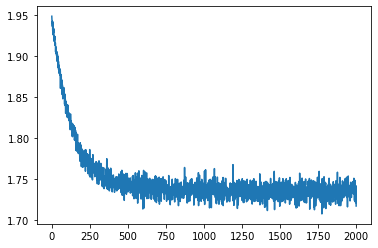

In [10]:
plt.plot(loss)

In [11]:
gr_fit = MoGrassmannBinary(model.sigma.detach(), model.p_mixing.detach())

In [12]:
# compare cov
print(gr.cov())
print(gr_fit.cov())

tensor([[ 0.1924, -0.0344,  0.0336],
        [-0.0344,  0.1924, -0.0336],
        [ 0.0336, -0.0336,  0.2244]])
tensor([[ 0.1923, -0.0354,  0.0341],
        [-0.0354,  0.1931, -0.0357],
        [ 0.0341, -0.0357,  0.2252]])


In [13]:
# compare means
print(gr.mean())
print(gr_fit.mean())

tensor([0.7400, 0.2600, 0.6600])
tensor([0.7402, 0.2614, 0.6574])


In [16]:
# compare mixing (can be different even for correct fitting)
print(gr.mixing_p)
print(model.p_mixing)

tensor([0.2000, 0.8000])
tensor([0.2668, 0.7332], grad_fn=<SoftmaxBackward0>)


In [17]:
# compare sigmas
print(sigma)
print(model.sigma)

tensor([[[ 0.5000,  0.3162,  0.0000],
         [-0.3162,  0.5000,  0.0000],
         [-0.0000, -0.0000,  0.1000]],

        [[ 0.8000,  0.2236,  0.0000],
         [ 0.2236,  0.2000,  0.0000],
         [ 0.0000,  0.0000,  0.8000]]])
tensor([[[ 0.3884, -0.1393,  0.1424],
         [-0.0451,  0.5157, -0.1202],
         [ 0.4980,  0.2851,  0.4831]],

        [[ 0.8683, -0.0181,  0.0613],
         [-0.0873,  0.1689, -0.2814],
         [-0.6833, -0.1391,  0.7208]]], grad_fn=<CopySlices>)
